# **Despliegue de modelos**
---


##**Infraestructura**
### **Nombre del modelo**
El modelo que se que se despliega a continuación recibe el nombre de **model_cafe**.

### **Plataforma de despliegue**
El modelo **model_cafe** será desplegado haciendo uso de **fastAPI**.

### **Requisitos técnicos**
Inicialmente se deberá crear un repositorio de git de la siguiente forma:
1. El nombre del repositorio debe ser stocks.
2. Debe ubicarse dentro del repositorio e inicializarlo con git.
3. Se debe escribir una clase que representará la entrada y la salida de un API para el modelo en fastapi.





## **Código de despliegue**

A continuación se implementa el código de despliegue.

In [1]:
!pip install fastapi

Se realiza la importación de las librerías necesarias

In [10]:
# Librerías de utilidad para manipulación y visualización de datos.
import joblib
import requests
import pandas as pd
import os
import subprocess
from sklearn.svm import SVR
from IPython.display import display
from pydantic import BaseModel
from typing import List
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


# Ignorar warnings.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Versiones de las librerías usadas
!python --version
import fastapi
print('FastAPI', fastapi.__version__)

Python 3.11.13
FastAPI 0.116.1


In [4]:
!git config --global user.email "atrillerasmar@unal.edu.co"
!git config --global user.name "atrillerasmar"
!git config --global init.defaultBranch master

In [5]:
# INGRESE SU CÓDIGO AQUÍ
!mkdir 'stocks'

In [6]:
%cd 'stocks'

/content/stocks


In [7]:
!git init

Initialized empty Git repository in /content/stocks/.git/


## **Cargue de los datos**

Los datos utilizados en este proyecto corresponden a variedades de café evaluadas por el Instituto de la Calidad del Café (Coffee Quality Institute, CQI por sus siglas en inglés), y están disponibles públicamente a través del siguiente enlace: https://database.coffeeinstitute.org/.

In [19]:
# Cargar el archivo CSV
df = pd.read_csv("/content/arabica_data_cleaned.csv")
#df.head(4)
# Preprocesamiento
df['Acidity'] = pd.to_numeric(df['Acidity'], errors='coerce')
df['Flavor'] = pd.to_numeric(df['Flavor'], errors='coerce')
df['Aftertaste'] = pd.to_numeric(df['Aftertaste'], errors='coerce')
df['Cupper.Points'] = pd.to_numeric(df['Cupper.Points'], errors='coerce')
df['Moisture'] = pd.to_numeric(df['Moisture'], errors='coerce')
df['Sweetness'] = pd.to_numeric(df['Sweetness'], errors='coerce')
df['Clean.Cup'] = pd.to_numeric(df['Clean.Cup'], errors='coerce')
df = df.apply(lambda col: col.fillna(col.mean()) if col.dtype in ['float64', 'int64'] else col)
columnas = ['Body', 'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness']
for col in columnas:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convierte a numérico si no lo es
    media_columna = df.loc[df[col] != 900, col].mean()  # Calcula la media sin incluir los 900
    df[col] = df[col].replace(900, media_columna)  # Reemplaza 900 por la media

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1311 non-null   int64  
 1   Species                1311 non-null   object 
 2   Owner                  1304 non-null   object 
 3   Country.of.Origin      1310 non-null   object 
 4   Farm.Name              955 non-null    object 
 5   Lot.Number             270 non-null    object 
 6   Mill                   1001 non-null   object 
 7   ICO.Number             1163 non-null   object 
 8   Company                1102 non-null   object 
 9   Altitude               1088 non-null   object 
 10  Region                 1254 non-null   object 
 11  Producer               1081 non-null   object 
 12  Number.of.Bags         1311 non-null   int64  
 13  Bag.Weight             1311 non-null   object 
 14  In.Country.Partner     1311 non-null   object 
 15  Harv

## **Definición del modelo**

A continuación se definen las variables de interés

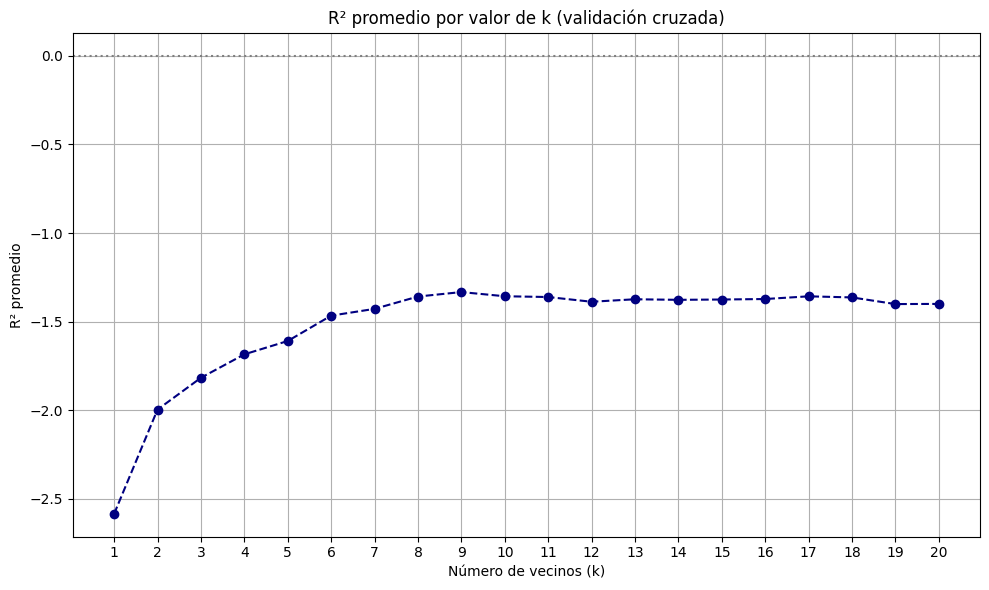

Mejor k: 9 con R² promedio de: -1.3330


In [20]:

X = df[['Body', 'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points', 'Moisture', 'Flavor', 'Aftertaste', 'Acidity']]  # ajusta si es necesario
y = df["Total.Cup.Points"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
k_values = range(1, 21)
r2_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='r2')
    r2_scores.append(np.mean(scores))

plt.figure(figsize=(10, 6))
plt.plot(k_values, r2_scores, marker='o', linestyle='--', color='navy')
plt.title("R² promedio por valor de k (validación cruzada)")
plt.xlabel("Número de vecinos (k)")
plt.ylabel("R² promedio")
plt.grid(True)
plt.xticks(k_values)
plt.axhline(0, color='gray', linestyle=':')
plt.tight_layout()
plt.show()

mejor_k = k_values[np.argmax(r2_scores)]
mejor_r2 = max(r2_scores)
print(f"Mejor k: {mejor_k} con R² promedio de: {mejor_r2:.4f}");

In [21]:
from sklearn.ensemble import RandomForestRegressor

# Entrenar modelo
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Obtener importancia
importancia_rf = pd.Series(rf.feature_importances_, index=X.columns)
importancia_rf = importancia_rf.sort_values(ascending=False)

# Mostrar
print("Importancia según Random Forest:")
print(importancia_rf)

Importancia según Random Forest:
Flavor           0.316103
Clean.Cup        0.165852
Cupper.Points    0.134432
Aftertaste       0.108604
Sweetness        0.068634
Body             0.064849
Acidity          0.056179
Balance          0.048383
Uniformity       0.034427
Moisture         0.002538
dtype: float64


MSE: 0.7298083001427929
R² score: 0.8832614669031267


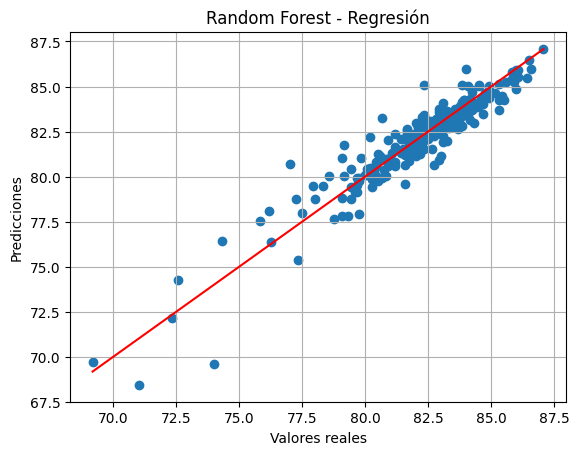

In [28]:
X = df[['Flavor', 'Clean.Cup', 'Cupper.Points', 'Aftertaste']]
y = df["Total.Cup.Points"]

# 2. Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Crear el modelo Random Forest
model_cafe = RandomForestRegressor(n_estimators=100, random_state=42)

# 4. Entrenar el modelo
model_cafe.fit(X_train, y_train)

# 5. Hacer predicciones
y_pred = model_cafe.predict(X_test)

# 6. Evaluar el modelo
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² score:", r2_score(y_test, y_pred))

# 7. Visualizar predicciones vs. valores reales
plt.scatter(y_test, y_pred)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Random Forest - Regresión")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red")
plt.grid(True)
plt.show()

In [29]:
model_cafe = RandomForestRegressor(random_state=42)

# Validación cruzada de 5 pliegues (K=5), usando R² como métrica
scores = cross_val_score(model_cafe, X, y, cv=5, scoring='r2')

# Mostrar resultados
print("Scores individuales:", scores)
print("R² promedio:", np.mean(scores))
print("Desviación estándar:", np.std(scores))

Scores individuales: [-3.45063225 -5.26695813 -8.6315161  -5.15372033 -0.34258744]
R² promedio: -4.569082849194292
Desviación estándar: 2.699866291675848


## **Estructuración de API**

A continuación se escribe una clase que representará la entrada y la salida de un API para el modelo *modelo_cafe* en `fastapi`.

Para esto debe implementar las clases `ApiInput` y `ApiOutput` con las siguientes consideranciones:

- `ApiInput`: debe tener un atributo llamado `features` que tenga tipo `List[float]`.
- `ApiOutput`: debe tener un atributo llamado `forecast` que sea de tipo `float`.

In [24]:
# CLASE CALIFICADA ApiInput
from pydantic import BaseModel
from typing import List
# CLASE CALIFICADA ApiInput
class ApiInput(BaseModel):
    ### ESCRIBA SU CÓDIGO AQUÍ ###
    features: List[float]
    ### FIN DEL CÓDIGO ###

In [25]:
class ApiOutput(BaseModel):
    ### ESCRIBA SU CÓDIGO AQUÍ ###
    forecast: float
    ### FIN DEL CÓDIGO ###

# Función del API

En esta parte se implementa una función *predict* la cual a partir de la clase de entrada, genera la clase de salida por medio del modelo.  
Esta función toma como entrada un ApiInput y debe generar un ApiOutput al cargar y utilizar el modelo guardado en la ruta model.cafe.

Parámetros

data: un objeto de tipo ApiInput.  

Retorna

prediction: un objeto de tipo ApiOutput.

In [32]:
# FUNCIÓN CALIFICADA save_model
import joblib
def save_model(model, path):
    ### ESCRIBA SU CÓDIGO AQUÍ ###
    joblib.dump(model, path)
    ### FIN DEL CÓDIGO ###

In [33]:
save_model(model_cafe, "model_cafe.joblib")
!ls -sh

total 4.0K
4.0K model_cafe.joblib


In [34]:
save_model(model_cafe, "model_cafe.joblib")
comm = subprocess.check_output(['ls', '-sh'])
saved_directory = (comm.decode('utf-8')).split()

In [35]:
# FUNCIÓN CALIFICADA predict
import numpy as np
def predict(data: ApiInput) -> ApiOutput:
    ### ESCRIBA SU CÓDIGO AQUÍ ###
    # Cargar el modelo desde archivo
    model = joblib.load("model_cafe")

    # Realizar la predicción
    input_array = np.array(data.features).reshape(1, -1)
    forecast_value = model.predict(input_array)[0]

    # Retornar la predicción en formato ApiOutput
    prediction = ApiOutput(forecast=float(forecast_value))
    return prediction
    ### FIN DEL CÓDIGO ###

Con el siguiente código se implmenta la función

In [ ]:
inp = ApiInput(features=[2.6, 4.4, 1.78, 6.81, 9.2])
pred = predict(inp)
display(pred)